In [1]:
%pwd

'/home/ubuntu/mmseg0/mmsegmentation'

In [2]:
import torch
print(torch.__version__, torch.cuda.is_available())
import mmseg
print(mmseg.__version__)
from mmseg.apis import inference_segmentor, show_result_pyplot
from mmseg.core.evaluation import get_palette
import mmcv
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os.path as osp
import numpy as np
from PIL import Image

1.12.1 True


/home/ubuntu/.conda/envs/mmseg0/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


0.30.0


In [3]:
# define dataset root and directory for images and annotations
data_root = 'data/IonoSeg'
img_dir = 'rgbimg'
ann_dir = 'rgbmask'
catogory_id_dir = 'label'
# define class and palette for better visualization
classes = ('Background', 'E', 'Es-l', 'Es-c', 'F1', 'F2', 'Spread-F')
palette = [[230, 230, 230], [250, 165, 30], [120, 69, 125], [53, 125, 34],
           [0, 11, 123], [130, 20, 12], [120, 121, 80]]    

In [4]:
from mmseg.datasets.builder import DATASETS
from mmseg.datasets.custom import CustomDataset

@DATASETS.register_module()
class IonogramSegmentationDataset(CustomDataset):
  CLASSES = classes
  PALETTE = palette
  def __init__(self, split, **kwargs):
    super().__init__(img_suffix='.png', seg_map_suffix='.png', 
                     split=split, **kwargs)
    assert osp.exists(self.img_dir) and self.split is not None

In [5]:
from mmcv import Config
cfg = Config.fromfile('configs/pspnet/pspnet_r50-d8_512x1024_40k_cityscapes.py')

In [6]:
from mmseg.apis import set_random_seed

# Since we use ony one GPU, BN is used instead of SyncBN
cfg.norm_cfg = dict(type='BN', requires_grad=True)
cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg
cfg.model.auxiliary_head.norm_cfg = cfg.norm_cfg

# Class Balanced Loss
cfg.model.decode_head.loss_decode = dict(type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0, class_weight=[0.2, 1.4, 4, 6, 2, 1, 2])
cfg.model.auxiliary_head.loss_decode = dict(type='CrossEntropyLoss', use_sigmoid=False, loss_weight=0.4, class_weight=[0.2, 1.4, 4, 6, 2, 1, 2])

cfg.optimizer = dict(type='SGD', lr=1e-4, momentum=0.9, weight_decay=0.0005)    
cfg.lr_config = dict(policy='poly', power=0.9, min_lr=1e-4, by_epoch=False)

## modify num classes of the model in decode/auxiliary head
cfg.model.decode_head.num_classes = 7
cfg.model.auxiliary_head.num_classes = 7

# Modify dataset type and path
cfg.dataset_type = 'IonogramSegmentationDataset'
cfg.data_root = data_root

cfg.data.samples_per_gpu = 8
cfg.data.workers_per_gpu = 8 

cfg.img_norm_cfg = dict(
    mean=[5.45, 5.45, 5.45], std=[13.12, 13.12, 13.12],  to_rgb=False)

cfg.crop_size = (512, 512)

cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='RandomFlip', flip_ratio=0),
    dict(type='PhotoMetricDistortion'),
    dict(type='Normalize', **cfg.img_norm_cfg),
    dict(type='Pad', size=cfg.crop_size, pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg']),
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(360, 400), # image scale
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(type='Normalize', **cfg.img_norm_cfg),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),
        ])
]

cfg.data.train.type = cfg.dataset_type
cfg.data.train.data_root = cfg.data_root
cfg.data.train.img_dir = img_dir
cfg.data.train.ann_dir = ann_dir
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = 'splits0/train.txt'

cfg.data.val.type = cfg.dataset_type
cfg.data.val.data_root = cfg.data_root
cfg.data.val.img_dir = img_dir
cfg.data.val.ann_dir = ann_dir
cfg.data.val.pipeline = cfg.test_pipeline
cfg.data.val.split = 'splits0/val.txt'

cfg.data.test.type = cfg.dataset_type
cfg.data.test.data_root = cfg.data_root
cfg.data.test.img_dir = img_dir
cfg.data.test.ann_dir = ann_dir
cfg.data.test.pipeline = cfg.test_pipeline
cfg.data.test.split = 'splits0/test.txt'

cfg.load_from = '/home/ubuntu/mmsegmentation/work_dirs/se4ionogram/pspnet_r50_ionogram_iou_3922_acc_9153.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './work_dirs/se4ionogram'

cfg.runner.max_iters = 10
cfg.log_config.interval = 1
cfg.evaluation.interval = 10
cfg.checkpoint_config.interval = 10

cfg.checkpoint_config.meta = dict(
    CLASSES=classes,
    PALETTE=palette)

# Set seed to facitate reproducing the result
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.device='cuda'
cfg.gpu_ids = range(1) 

# Let's have a look at the final config used for training
print(f'Config:\n{cfg.pretty_text}')
Config.dump(cfg, './work_dirs/se4ionogram/pspnet_r50_ionogram_mmseg0.py')

Config:
norm_cfg = dict(type='BN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained='open-mmlab://resnet50_v1c',
    backbone=dict(
        type='ResNetV1c',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        dilations=(1, 1, 2, 4),
        strides=(1, 2, 1, 1),
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=False,
        style='pytorch',
        contract_dilation=True),
    decode_head=dict(
        type='PSPHead',
        in_channels=2048,
        in_index=3,
        channels=512,
        pool_scales=(1, 2, 3, 6),
        dropout_ratio=0.1,
        num_classes=7,
        norm_cfg=dict(type='BN', requires_grad=True),
        align_corners=False,
        loss_decode=dict(
            type='CrossEntropyLoss',
            use_sigmoid=False,
            loss_weight=1.0,
            class_weight=[0.2, 1.4, 4, 6, 2, 1, 2])),
    auxiliary_head=dict(
        type='FCNHead',
        in_channels=1024,
        i

In [7]:
from mmseg.datasets import build_dataset
from mmseg.models import build_segmentor
from mmseg.apis import train_segmentor

# Build the dataset
datasets = [build_dataset(cfg.data.train)]
# cfg.device = 'cuda:0'
# Build the detector
model = build_segmentor(
    cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES
model.PALLETTE = datasets[0].PALETTE
# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_segmentor(model, datasets, cfg, distributed=False, validate=True, 
                meta=dict())

2023-02-12 22:30:50,961 - mmseg - INFO - Loaded 3000 images
/home/ubuntu/mmseg0/mmsegmentation/mmseg/models/backbones/resnet.py:431: UserWarning: DeprecationWarning: pretrained is a deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is a deprecated, '
/home/ubuntu/mmseg0/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:235: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(
2023-02-12 22:30:52,831 - mmseg - INFO - Loaded 448 images
2023-02-12 22:30:52,833 - mmseg - INFO - load checkpoint from local path: /home/ubuntu/mmsegmentation/work_dirs/se4ionogram/pspnet_r50_ionogram_iou_3922_acc_9153.pth
2023-02-12 22:30:53,125 - mmseg - INFO - Start running, host: ubuntu@VM-0-3-ubuntu, work_dir: /home/ubuntu/mmseg0/mmsegmentation/work_dirs/se4ionogram
2023-02-12 22

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 448/448, 35.2 task/s, elapsed: 13s, ETA:     0s

2023-02-12 22:31:18,294 - mmseg - INFO - per class results:
2023-02-12 22:31:18,295 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| Background | 99.49 |  99.5 |
|     E      | 24.07 | 94.98 |
|    Es-l    | 22.92 | 99.93 |
|    Es-c    | 20.08 | 95.48 |
|     F1     | 29.99 | 93.89 |
|     F2     | 39.97 | 96.99 |
|  Spread-F  | 22.18 | 99.22 |
+------------+-------+-------+
2023-02-12 22:31:18,296 - mmseg - INFO - Summary:
2023-02-12 22:31:18,296 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 99.49 | 36.96 | 97.14 |
+-------+-------+-------+
2023-02-12 22:31:18,297 - mmseg - INFO - Iter(val) [448]	aAcc: 0.9949, mIoU: 0.3696, mAcc: 0.9714, IoU.Background: 0.9949, IoU.E: 0.2407, IoU.Es-l: 0.2292, IoU.Es-c: 0.2008, IoU.F1: 0.2999, IoU.F2: 0.3997, IoU.Spread-F: 0.2218, Acc.Background: 0.9950, Acc.E: 0.9498, Acc.Es-l: 0.9993, Acc.Es-c: 0.9548, Acc.F1: 0.9389, Acc.F2: 0.9699, 

/home/ubuntu/mmseg0/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


<Figure size 800x400 with 0 Axes>

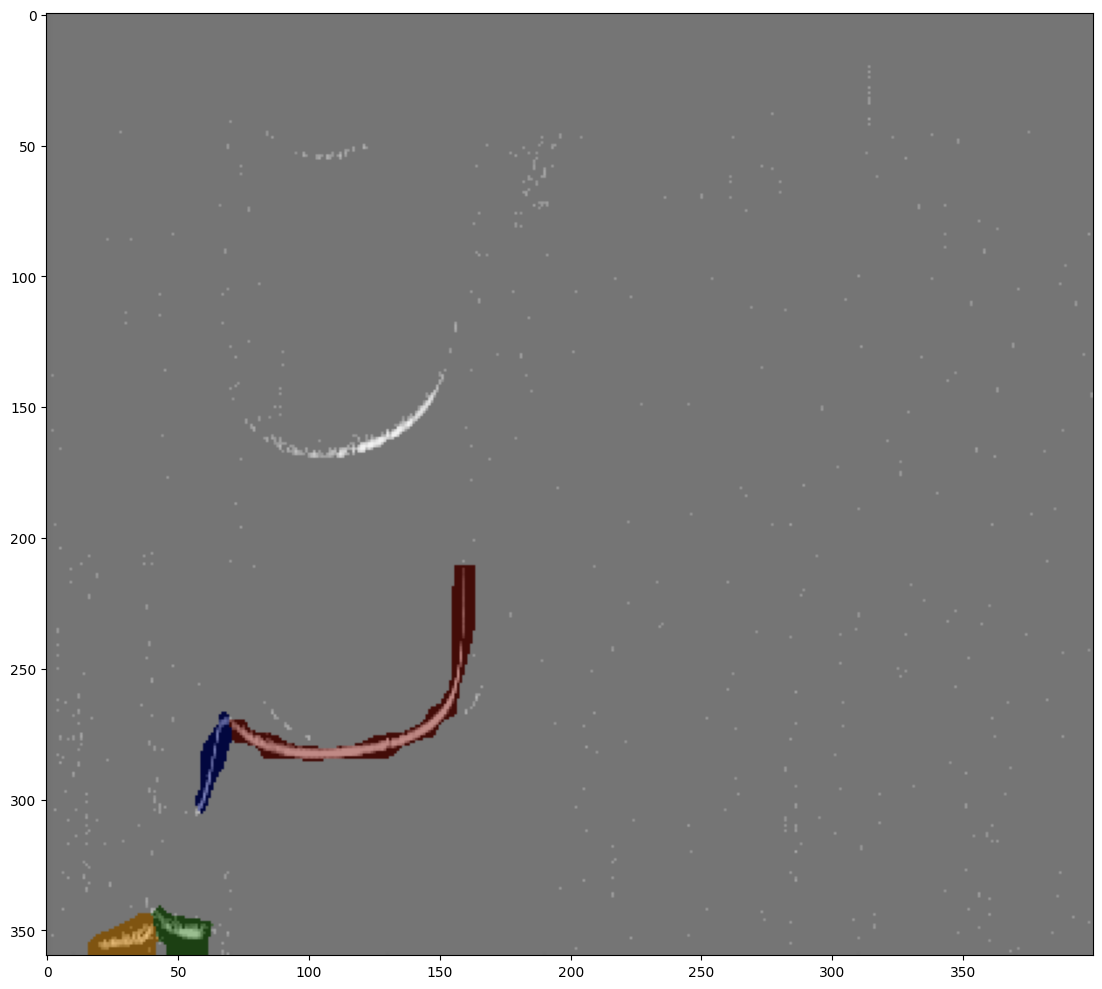

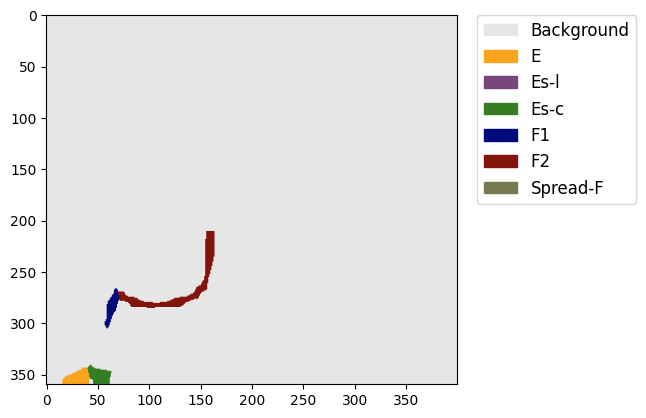

In [8]:
img = mmcv.imread(osp.join(data_root, img_dir, '20191031101500.png'))
model.cfg = cfg
result = inference_segmentor(model, img)
plt.figure(figsize=(8, 4))

show_result_pyplot(model, img, result, palette)

# draw the legend
seg_res = Image.fromarray(np.uint8(result[0])).convert('P')
seg_res.putpalette(np.array(palette, dtype=np.uint8))
plt.figure(figsize=(8, 6))
im = plt.imshow(np.array(seg_res.convert('RGB')))
# create a patch (proxy artist) for every color 
patches = [mpatches.Patch(color=np.array(palette[i])/255.,label=classes[i]) for i in range(7)]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, fontsize='large')
plt.show()
